## Importing the libraries

In [1]:
import numpy as np 
import pandas as pd 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix,f1_score

import os

import seaborn as sns
import re
import matplotlib.pyplot as plt
%matplotlib inline

## Importing the dataset

In [2]:
training_data = pd.read_csv('train_E6oV3lV.csv')
testing_data = pd.read_csv('test_tweets_anuFYb8.csv') 

In [3]:
print("Training Set:", training_data.shape)
print("Test Set:", testing_data.shape)

Training Set: (31962, 3)
Test Set: (17197, 2)


## Taking care of missing data

In [4]:
print('-----Train_Set -----')
print(training_data.isnull().sum())
print('-----Test_set -----')
print(testing_data.isnull().sum())
training_data.head()

-----Train_Set -----
id       0
label    0
tweet    0
dtype: int64
-----Test_set -----
id       0
tweet    0
dtype: int64


,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [5]:
training_data['label'].value_counts() #counting no of positives and negatives

0    29720
1     2242
Name: label, dtype: int64

In [6]:
def createPieChartFor(t_df):
    Lst = 100*t_df.value_counts()/len(t_df)
    
    # set data for pie chart
    labels = t_df.value_counts().index.values
    sizes =  Lst 
    
    # set labels
    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, labels=labels, autopct='%1.2f%%', shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()

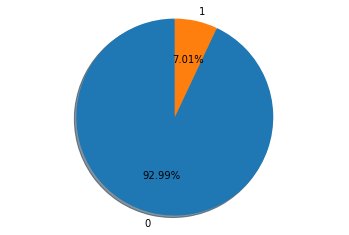

0    29720
1     2242
Name: label, dtype: int64


In [7]:
createPieChartFor(training_data.label)

print(training_data.label.value_counts())

## Text Cleaning

In [8]:
import re
from sklearn.utils import resample
import nltk
#from wordcloud import WordCloud, STOPWORDS

from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

eng_stops = set(stopwords.words("english"))
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()

def cleandata(review_text):
    # remove all the special characters
    new_review_text = re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", review_text) 
    # convert all letters to lower case
    words = new_review_text.lower().split()
    # remove stop words
    words = [w for w in words if not w in eng_stops]    
    # lemmatizer
    words = [lemmatizer.lemmatize(word) for word in words]
    # join all words back to text
    return (" ".join(words))

training_data['clean_tweet']=training_data['tweet'].apply(lambda x: cleandata(x))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [9]:
training_data.head()

,id,label,tweet,clean_tweet
0,1,0,@user when a father is dysfunctional and is s...,father dysfunctional selfish drag kid dysfunct...
1,2,0,@user @user thanks for #lyft credit i can't us...,thanks lyft credit cant use cause dont offer w...
2,3,0,bihday your majesty,bihday majesty
3,4,0,#model i love u take with u all the time in ...,model love u take u time ur
4,5,0,factsguide: society now #motivation,factsguide society motivation


## EDA

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


,id,label,tweet,clean_tweet,length
0,1,0,@user when a father is dysfunctional and is s...,father dysfunctional selfish drag kid dysfunct...,102
1,2,0,@user @user thanks for #lyft credit i can't us...,thanks lyft credit cant use cause dont offer w...,122
2,3,0,bihday your majesty,bihday majesty,21
3,4,0,#model i love u take with u all the time in ...,model love u take u time ur,86
4,5,0,factsguide: society now #motivation,factsguide society motivation,39


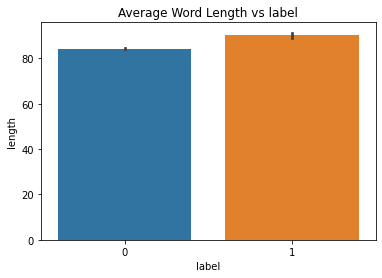

In [10]:
training_data['length'] = training_data['tweet'].apply(len)
fig1 = sns.barplot('label','length',data = training_data)
plt.title('Average Word Length vs label')
plot = fig1.get_figure()
training_data.head()

Text(0.5, 1.0, 'Positive and Negative Label Counts')

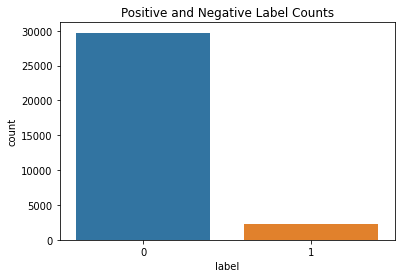

In [11]:
fig2 = sns.countplot(x= 'label',data = training_data)
plt.title('Positive and Negative Label Counts')

In [12]:
#Upsample

count_non_hate = training_data[training_data['label'] == 0]['clean_tweet'].count()
df_hate_speech = training_data[training_data['label'] == 1]
df_non_hate_speech = training_data[training_data['label'] == 0]
df_hate_speech_oversample = df_hate_speech.sample(count_non_hate, replace=True)
train_df_oversampled = pd.concat([df_non_hate_speech, df_hate_speech_oversample], axis=0)

print('Random over-sampling:')
print(train_df_oversampled['label'].value_counts())

Random over-sampling:
0    29720
1    29720
Name: label, dtype: int64


In [13]:
#Downsample

count_hate = training_data[training_data['label'] == 1]['clean_tweet'].count()
df_non_hate_speech = training_data[training_data['label'] == 0]
df_hate_speech = training_data[training_data['label'] == 1]
df_hate_speech_undersample = df_non_hate_speech.sample(count_hate, replace=True)
train_df_undersampled = pd.concat([df_hate_speech, df_hate_speech_undersample], axis=0)

print('Random under-sampling:')
print(train_df_undersampled['label'].value_counts())

Random under-sampling:
1    2242
0    2242
Name: label, dtype: int64


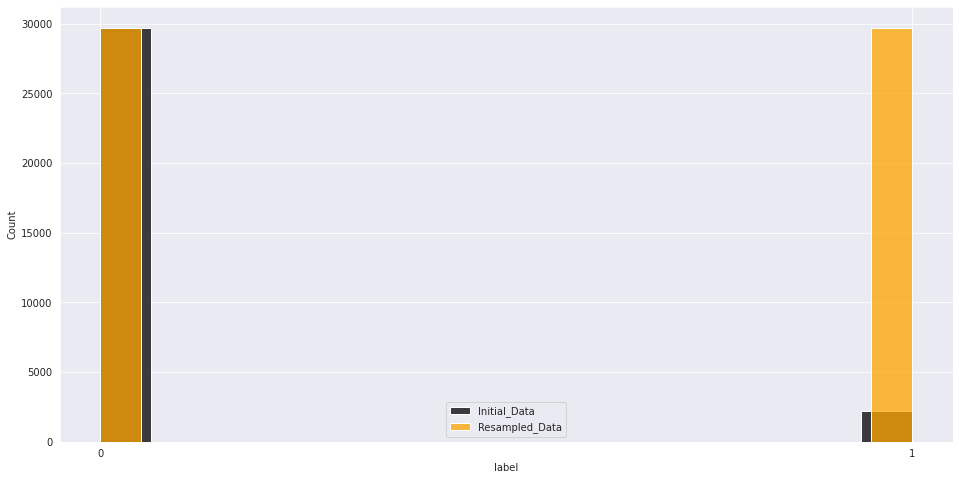

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16,8))
sns.set_style('darkgrid')
sns.histplot(data = training_data['label'], color='black', legend=True)
sns.histplot(data = train_df_oversampled['label'], color = 'orange', legend=True)
plt.legend(['Initial_Data', 'Resampled_Data'])
plt.xticks([0, 1]) 
plt.show()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


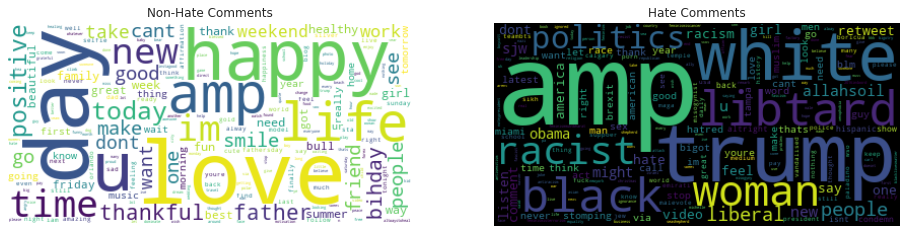

In [15]:
!pip install wordcloud
import os
import matplotlib.pyplot as plt
from wordcloud import WordCloud

fig, axs = plt.subplots(1,2 , figsize=(16,8))
text_pos = " ".join(training_data['clean_tweet'][training_data.label == 0])
text_neg = " ".join(training_data['clean_tweet'][training_data.label == 1])
train_cloud_pos = WordCloud(collocations = False, background_color = 'white').generate(text_pos)
train_cloud_neg = WordCloud(collocations = False, background_color = 'black').generate(text_neg)
axs[0].imshow(train_cloud_pos, interpolation='bilinear')
axs[0].axis('off')
axs[0].set_title('Non-Hate Comments')
axs[1].imshow(train_cloud_neg, interpolation='bilinear')
axs[1].axis('off')
axs[1].set_title('Hate Comments')

plt.show()

## Model Building

In [16]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

train_df, test_df =  train_test_split(train_df_oversampled, test_size = 0.2, random_state = 42)

#Feature Extraction

vectorizer = TfidfVectorizer()
train_tfidf_model = vectorizer.fit_transform(train_df.clean_tweet)
test_tfidf_model = vectorizer.transform(test_df.clean_tweet)
train_tfidf = pd.DataFrame(train_tfidf_model)

from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from catboost import CatBoostClassifier

from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report

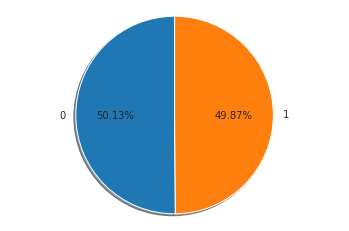

0    23840
1    23712
Name: label, dtype: int64


In [18]:
# to account for data imbalance

createPieChartFor(train_df.label)

print(train_df.label.value_counts())

In [19]:
train_tfidf_model

<47552x34005 sparse matrix of type '<class 'numpy.float64'>'
	with 365609 stored elements in Compressed Sparse Row format>

In [20]:
train_tfidf

,0
0,"(0, 29060)\t0.3060105294250058\n (0, 2127)\..."
1,"(0, 2509)\t0.5022950279861709\n (0, 6902)\t..."
2,"(0, 3777)\t0.3714290441445574\n (0, 173)\t0..."
3,"(0, 30460)\t0.3462201030785978\n (0, 16344)..."
4,"(0, 12635)\t0.3372068473549806\n (0, 12275)..."
...,...
47547,"(0, 18013)\t0.3768690798688915\n (0, 5732)\..."
47548,"(0, 25266)\t0.8163643438537342\n (0, 23395)..."
47549,"(0, 33543)\t0.8150984588024998\n (0, 31903)..."
47550,"(0, 7211)\t0.4866958697756266\n (0, 13440)\..."


In [21]:
cls = [LogisticRegression(),
       MultinomialNB(), 
       DecisionTreeClassifier(),
       RandomForestClassifier(n_estimators=200),
       KNeighborsClassifier(n_neighbors = 5),
      SGDClassifier(),
      LinearSVC(),
      AdaBoostClassifier(n_estimators=100),
      CatBoostClassifier(verbose=0)]

cls_name = []

In [22]:
train_df['label']

19396    1
8170     1
19897    0
24176    1
268      0
        ..
16356    1
20412    1
930      0
16981    0
6067     1
Name: label, Length: 47552, dtype: int64

In [23]:
test_tfidf_model

<11888x34005 sparse matrix of type '<class 'numpy.float64'>'
	with 86985 stored elements in Compressed Sparse Row format>

In [24]:
test_df

,id,label,tweet,clean_tweet,length
21960,21961,0,@user is this for real? #waspi 50sborn in abje...,real waspi 50sborn abject povey together,93
21181,21182,0,shit happens but life goes on. good blessðð...,shit happens life go good bless day,64
10804,10805,1,i'm trying so hard to make your handwritten in...,im trying hard make handwritten indirect prett...,98
18718,18719,0,with so many delicious burger &amp; entree sel...,many delicious burger amp entree selection one...,112
14896,14897,0,@user i wanna see it. #shohairclub,wanna see shohairclub,36
...,...,...,...,...,...
7844,7845,0,i tell you he's a gop mole !,tell he gop mole,29
15523,15524,1,a white-skinned woman's unfair experience of ...,whiteskinned woman unfair experience india via,66
3087,3088,0,"@user #money can't make you , but it is bett...",money cant make better cry yacht hilarious cam...,114
28294,28295,1,@user #newyear 'wish list' of cretin #carlpal...,newyear wish list cretin carlpaladinoelection ...,116


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression  Accuracy Score : 97.48%
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      5683
           1       0.99      0.96      0.98      6205

    accuracy                           0.97     11888
   macro avg       0.97      0.98      0.97     11888
weighted avg       0.98      0.97      0.97     11888

Confusion_Matrix: 
[[5957  248]
 [  51 5632]]
F1 Score:  0.9755178907721281


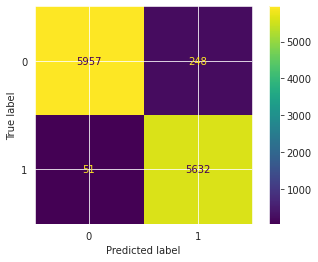

MultinomialNB  Accuracy Score : 95.42%
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      5504
           1       0.99      0.93      0.96      6384

    accuracy                           0.95     11888
   macro avg       0.95      0.96      0.95     11888
weighted avg       0.96      0.95      0.95     11888

Confusion_Matrix: 
[[5924  460]
 [  84 5420]]
F1 Score:  0.9561007101355714


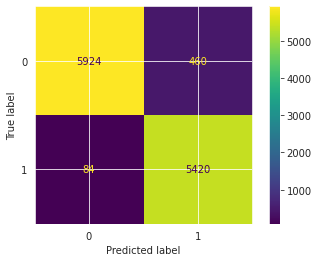

DecisionTreeClassifier  Accuracy Score : 95.35%
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      5327
           1       1.00      0.92      0.96      6561

    accuracy                           0.95     11888
   macro avg       0.95      0.96      0.95     11888
weighted avg       0.96      0.95      0.95     11888

Confusion_Matrix: 
[[6008  553]
 [   0 5327]]
F1 Score:  0.9560028641896731


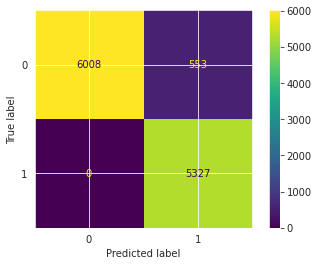

RandomForestClassifier  Accuracy Score : 98.34%
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      5683
           1       1.00      0.97      0.98      6205

    accuracy                           0.98     11888
   macro avg       0.98      0.98      0.98     11888
weighted avg       0.98      0.98      0.98     11888

Confusion_Matrix: 
[[6008  197]
 [   0 5683]]
F1 Score:  0.9838696470973552


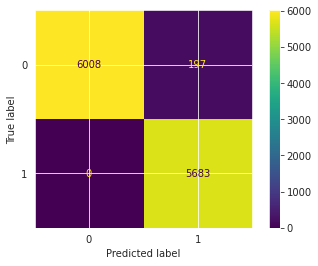

KNeighborsClassifier  Accuracy Score : 72.45%
              precision    recall  f1-score   support

           0       0.44      1.00      0.61      2605
           1       1.00      0.65      0.79      9283

    accuracy                           0.72     11888
   macro avg       0.72      0.82      0.70     11888
weighted avg       0.88      0.72      0.75     11888

Confusion_Matrix: 
[[6008 3275]
 [   0 2605]]
F1 Score:  0.7858217251978287


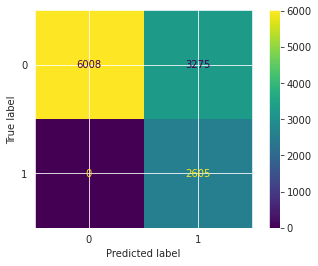

SGDClassifier  Accuracy Score : 97.11%
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      5712
           1       0.99      0.96      0.97      6176

    accuracy                           0.97     11888
   macro avg       0.97      0.97      0.97     11888
weighted avg       0.97      0.97      0.97     11888

Confusion_Matrix: 
[[5920  256]
 [  88 5624]]
F1 Score:  0.9717662508207485


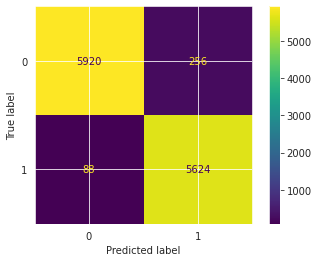

LinearSVC  Accuracy Score : 98.54%
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      5728
           1       1.00      0.97      0.99      6160

    accuracy                           0.99     11888
   macro avg       0.99      0.99      0.99     11888
weighted avg       0.99      0.99      0.99     11888

Confusion_Matrix: 
[[5997  163]
 [  11 5717]]
F1 Score:  0.9857001972386589


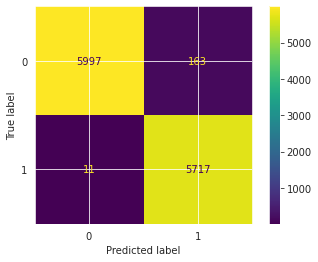

AdaBoostClassifier  Accuracy Score : 81.4%
              precision    recall  f1-score   support

           0       0.93      0.75      0.83      7287
           1       0.70      0.91      0.79      4601

    accuracy                           0.81     11888
   macro avg       0.82      0.83      0.81     11888
weighted avg       0.84      0.81      0.82     11888

Confusion_Matrix: 
[[4199  402]
 [1809 5478]]
F1 Score:  0.7915920444905269


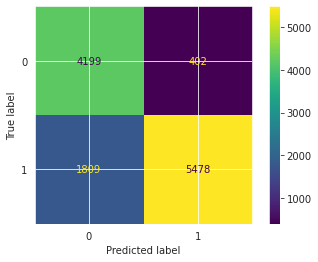

CatBoostClassifier  Accuracy Score : 97.0%
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      5649
           1       0.99      0.95      0.97      6239

    accuracy                           0.97     11888
   macro avg       0.97      0.97      0.97     11888
weighted avg       0.97      0.97      0.97     11888

Confusion_Matrix: 
[[5945  294]
 [  63 5586]]
F1 Score:  0.9708500040826324


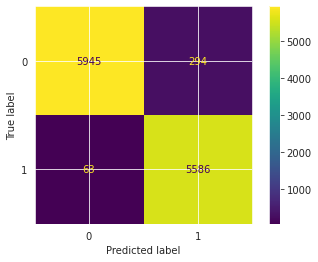

In [25]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, precision_recall_curve, precision_recall_fscore_support, ConfusionMatrixDisplay

truelbl = test_df.label
i = 0
accuracy = []
precision = []
recall = []
f1_score_list = []
model_metrics = []
for cl in cls:
    model = cl.fit(train_tfidf_model,train_df.label)
    lbl_pred = model.predict(test_tfidf_model)
    a = (100*accuracy_score(lbl_pred, truelbl))
    a = round(a,2)
    accuracy.append(a)
    cls_name.append(cl.__class__.__name__)

    #Classification Report
    print ("{}  Accuracy Score : {}%".format(cls_name[i],a))
    print ( classification_report(lbl_pred, truelbl))

    #Precision Recall f1score support
    x = precision_recall_fscore_support(lbl_pred, truelbl)
    model_metrics.append(x)
    #Confusion Matrix

    print('Confusion_Matrix: ')
    cm = confusion_matrix(truelbl, lbl_pred, labels = [1,0]).T
    print(cm)
    precision_ = precision_score(truelbl, lbl_pred, labels = [1,0])
    precision.append(precision_)
    recall_ = recall_score(truelbl, lbl_pred, labels = [1,0])
    recall.append(recall_)
    f1_ = f1_score(truelbl, lbl_pred, labels = [1,0])
    f1_score_list.append(f1_)
    print('F1 Score: ', f1_)


    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    plt.show()

    #model.save
    i +=1

In [26]:
cls_name

['LogisticRegression',
 'MultinomialNB',
 'DecisionTreeClassifier',
 'RandomForestClassifier',
 'KNeighborsClassifier',
 'SGDClassifier',
 'LinearSVC',
 'AdaBoostClassifier',
 'CatBoostClassifier']

([0, 1, 2, 3, 4, 5, 6, 7, 8], <a list of 9 Text major ticklabel objects>)

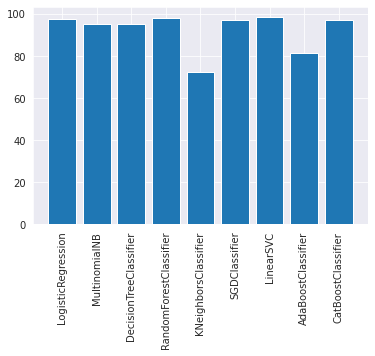

In [27]:
plt.bar(cls_name, accuracy)
plt.xticks(rotation=90)

[0.9755178907721281,
 0.9561007101355714,
 0.9560028641896731,
 0.9838696470973552,
 0.7858217251978287,
 0.9717662508207485,
 0.9857001972386589,
 0.7915920444905269,
 0.9708500040826324]

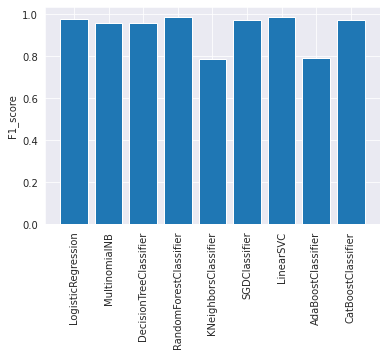

In [28]:
plt.bar(cls_name, f1_score_list)
plt.xticks(rotation=90)
plt.ylabel('F1_score')
f1_score_list

In [36]:
def predict(input):
    input = vectorizer.transform([cleandata(input)])
    yhat = model.predict(input)
    if yhat[0] == 1:
        print('Hate Comment Detected 😔')
    if yhat[0] == 0:
        print('All Good😄')
    
input = ['I hate humans', 'I love playing soccer ']
for i in input:
    print('Entered_Comment: ', i)
    predict(i)

Entered_Comment:  I hate humans
Hate Comment Detected 😔
Entered_Comment:  I love playing soccer 
All Good😄
